Shape: (50530, 12)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
 5   Year                           50530 non-null  int32         
 6   Month                          50530 non-null  int32         
 7   Day                            50530 non-null  int32         
 8   Hour                           50530 non-null  int32         
 9   Minute                         50530 non-null  int32         
 10  DayOfWeek                      50530 non-null  int3

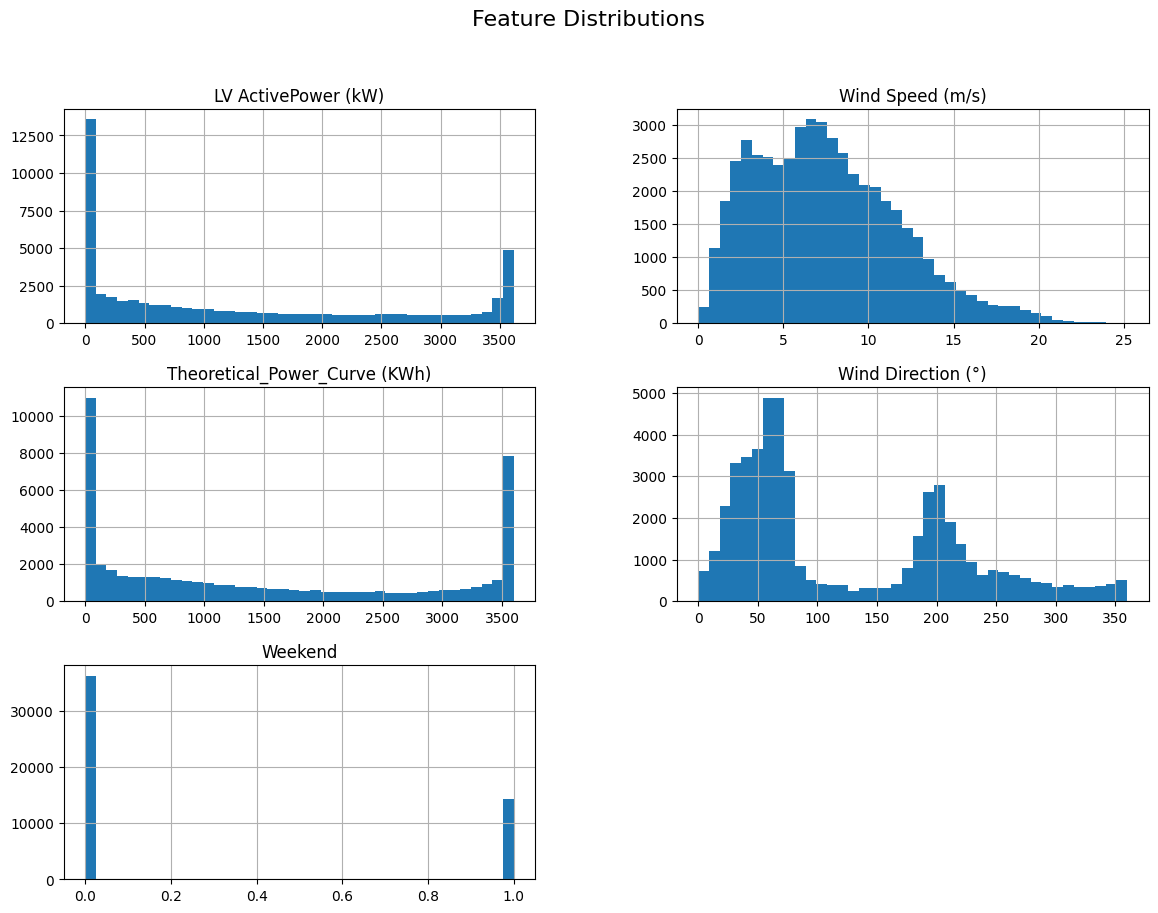

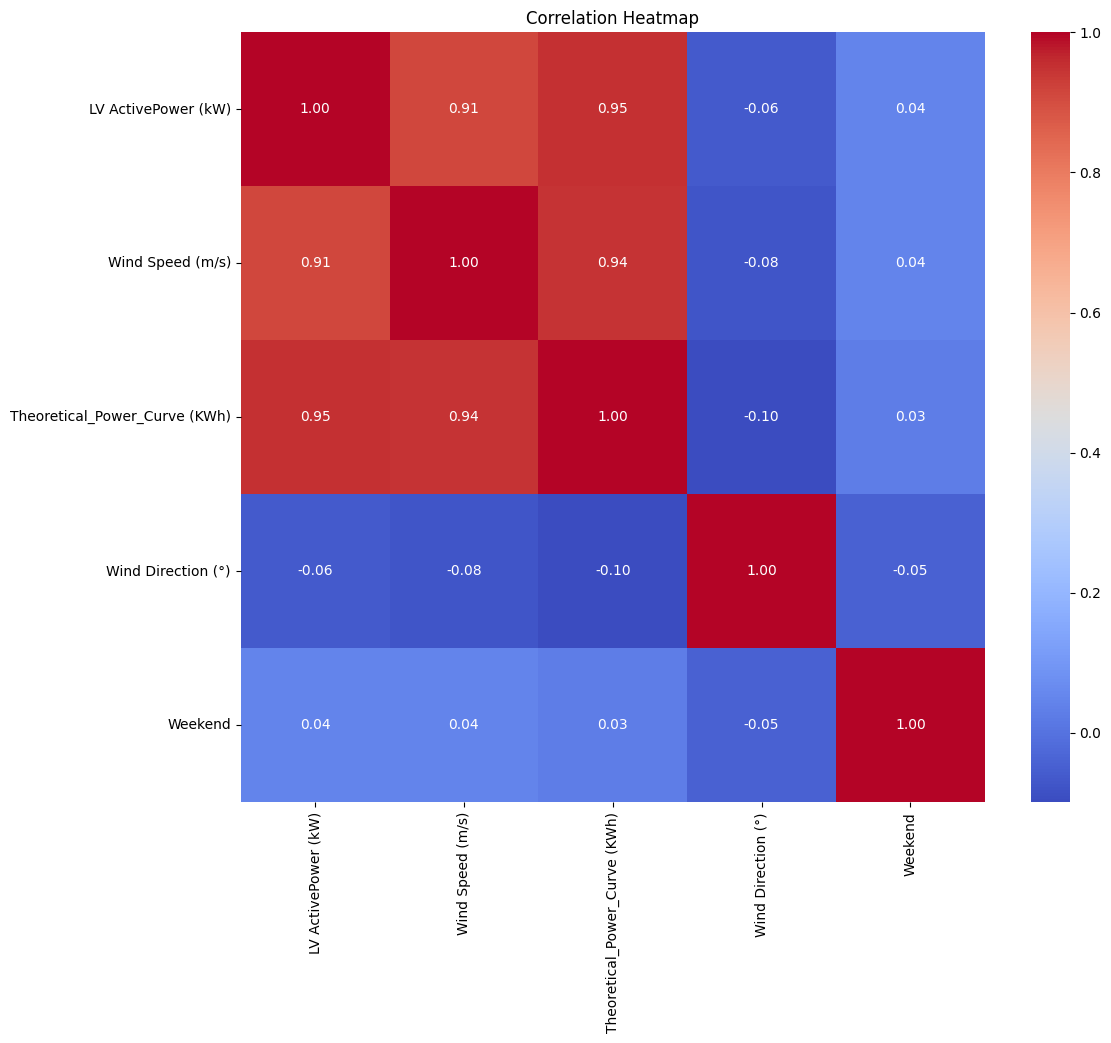

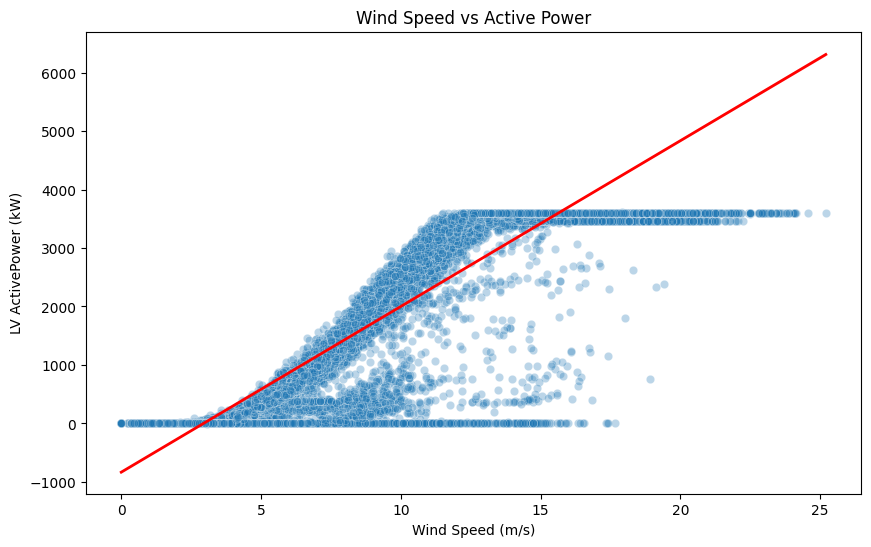

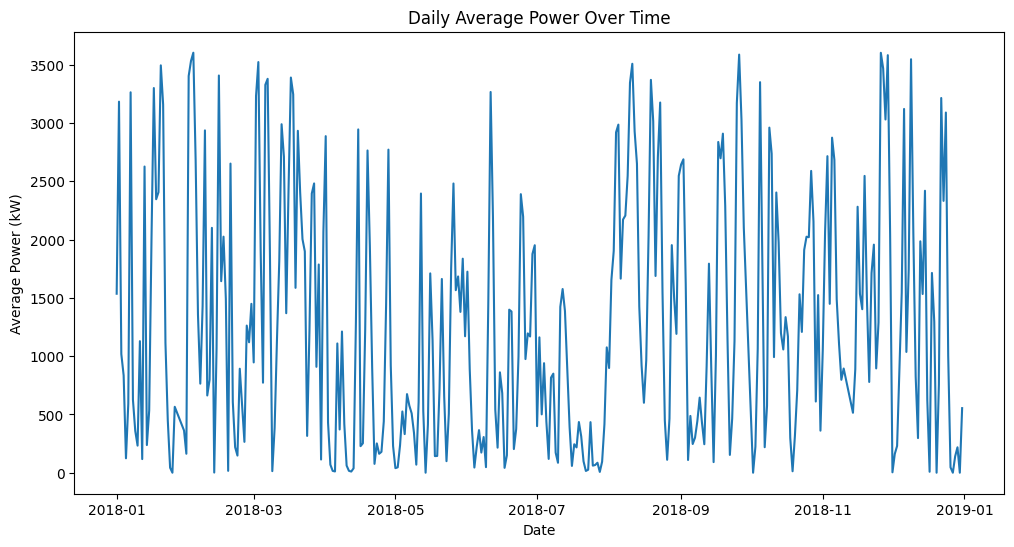

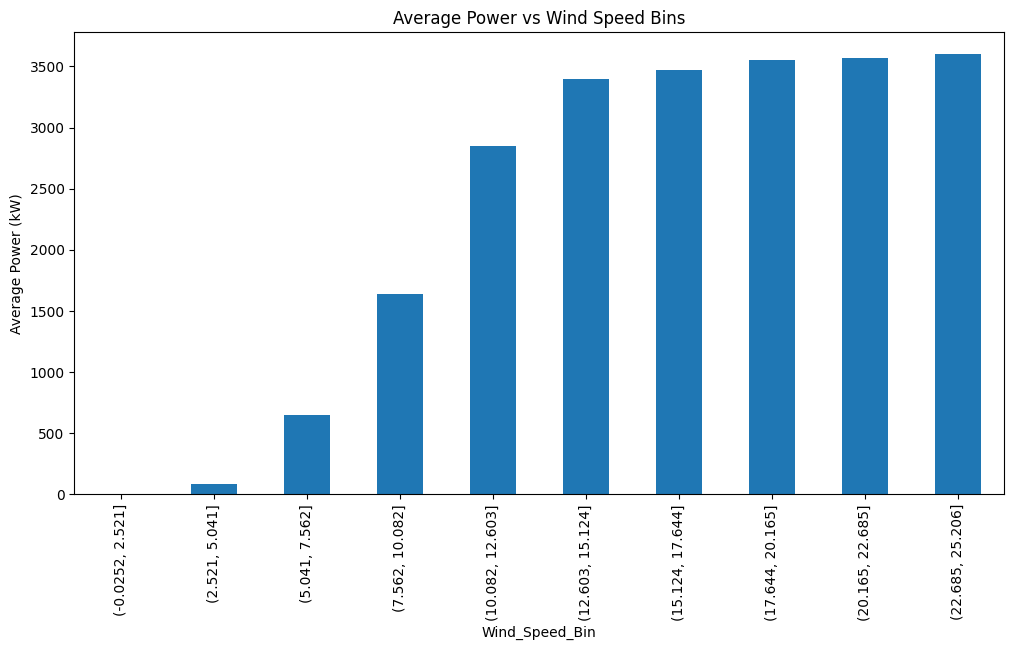


Linear Regression Performance:
RMSE: 408.47
MAE: 195.29
R²: 0.902

Random Forest Regressor Performance:
RMSE: 273.78
MAE: 101.53
R²: 0.956


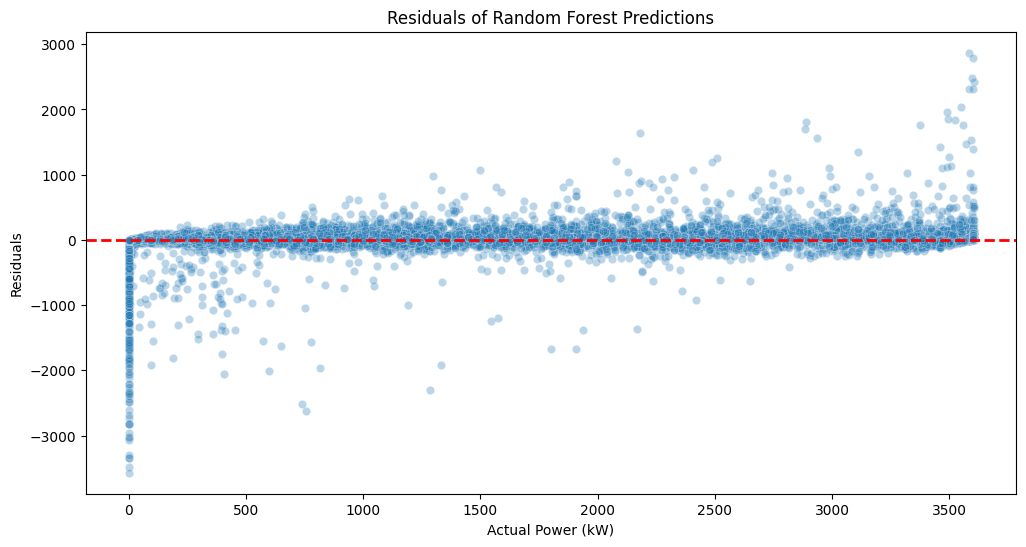

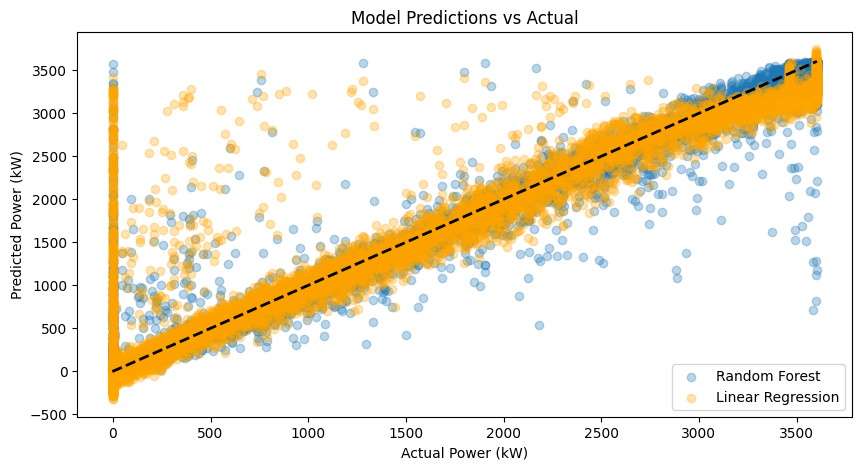

In [7]:
# Week 2: Advanced EDA + Feature Engineering + Model Selection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------
# Load Dataset
# ------------------------------
df = pd.read_csv("../data/greenAI_Data.csv")

# Convert 'Date/Time' to datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], dayfirst=True)

# ------------------------------
# Feature Engineering
# ------------------------------
df['Year'] = df['Date/Time'].dt.year
df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day
df['Hour'] = df['Date/Time'].dt.hour
df['Minute'] = df['Date/Time'].dt.minute
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# ------------------------------
# Exploratory Data Analysis
# ------------------------------
print("Shape:", df.shape)
print("\nData Info:")
print(df.info())

# Distribution of numeric columns
df.select_dtypes(include=['float64', 'int64']).hist(bins=40, figsize=(14,10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Correlation heatmap (numeric columns only)
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Scatter: Wind Speed vs Active Power with trendline
plt.figure(figsize=(10,6))
sns.scatterplot(x="Wind Speed (m/s)", y="LV ActivePower (kW)", data=df, alpha=0.3)
sns.regplot(x="Wind Speed (m/s)", y="LV ActivePower (kW)", data=df,
            scatter=False, color="red", line_kws={"linewidth":2})
plt.title("Wind Speed vs Active Power")
plt.show()

# Power over time (seasonality)
plt.figure(figsize=(12,6))
df.groupby(df['Date/Time'].dt.date)['LV ActivePower (kW)'].mean().plot()
plt.title("Daily Average Power Over Time")
plt.xlabel("Date")
plt.ylabel("Average Power (kW)")
plt.show()

# Wind Speed bins
df['Wind_Speed_Bin'] = pd.cut(df['Wind Speed (m/s)'], bins=10)
plt.figure(figsize=(12,6))
df.groupby('Wind_Speed_Bin', observed=True)['LV ActivePower (kW)'].mean().plot(kind='bar')
plt.ylabel("Average Power (kW)")
plt.title("Average Power vs Wind Speed Bins")
plt.show()

# ------------------------------
# Machine Learning Models
# ------------------------------

# Features & target
feature_cols = ["Wind Speed (m/s)", "Theoretical_Power_Curve (KWh)", 
                "Wind Direction (°)", "Hour", "Month", "Weekend"]
X = df[feature_cols]
y = df["LV ActivePower (kW)"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# ------------------------------
# Model Evaluation
# ------------------------------
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")

# Residuals plot
plt.figure(figsize=(12,6))
sns.scatterplot(x=y_test, y=y_test - y_pred_rf, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Power (kW)")
plt.ylabel("Residuals")
plt.title("Residuals of Random Forest Predictions")
plt.show()

# Predictions vs Actual
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label="Random Forest")
plt.scatter(y_test, y_pred_lr, alpha=0.3, label="Linear Regression", color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual Power (kW)")
plt.ylabel("Predicted Power (kW)")
plt.title("Model Predictions vs Actual")
plt.legend()
plt.show()
